### Load the dataset, set configs, etc.

In [1]:
from nltk import word_tokenize, pos_tag, ne_chunk
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import analyze_text as atxt
from nltk.tree import Tree
import matplotlib as mpl
import seaborn as sb
import pandas as pd
import gensim
import pickle
import nltk
%matplotlib inline

# Config
STARTING_K = 100 #200
LOAD_TFIDF = True
STOPWORDS_THRESHOLD = 0.3
K_THRESHOLD = 0.9
ENGLISH_STOPS = set(nltk.corpus.stopwords.words('english'))

# Give figures solid white backgrounds
p = plt.figure()
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['savefig.facecolor'] = 'white'
plt.close()

# Import the CNET dataset
df = pd.read_csv('cnet-classifications.csv')
df['labels_factor'] = pd.factorize(df['device_category'])[0]

# Import the Google Word2Vec
w2v = gensim.models.KeyedVectors.load_word2vec_format( \
    './GoogleNews-vectors-negative300.bin', binary=True, limit=500000)  

# Variables to update iteratively
iot_stops = set()
k = STARTING_K

# The tokenizer for TfidfVectorizer; also handles named entities, etc.
def tfidf_tokenizer(text):
    # Remove named entities
    # TODO necessary?
    named_entities = []
    chunked = ne_chunk(pos_tag(word_tokenize(text)))
    for chunk in chunked:
        if type(chunk) == Tree:
           ne = ' '.join([token for token, pos in chunk.leaves()])
           text = text.replace(ne, '')
    # Tokenize
    tokens = atxt.tokenize(text)
    tokens = [token for token in tokens if len(token) >= 4]
    tokens = [atxt.get_lemma(token) for token in tokens if atxt.get_lemma(token)]
    tokens = [token for token in tokens if token.isalpha()]
    return tokens

# The TF-IDF function
def tfidf(texts):
    tfidf_vectorizer = TfidfVectorizer(max_df=1.0, max_features=200000, min_df=0.0,
                                        stop_words=ENGLISH_STOPS.union(iot_stops),
                                        use_idf=True, lowercase=False,
                                        tokenizer=tfidf_tokenizer,
                                        ngram_range=(1,2))
    tfidf_matrix = tfidf_vectorizer.fit_transform(texts)
    feature_names = tfidf_vectorizer.get_feature_names()
    feature_indices = {doc: tfidf_matrix[doc,:].nonzero()[1]
                        for doc in range(tfidf_matrix.shape[0])}
    tfidf_scores = {doc: list(zip(ft_ind, [tfidf_matrix[doc,x] for x in ft_ind]))
                    for doc, ft_ind in feature_indices.items()}
    tfidf_sorted = {k: sorted(v, key=lambda x: x[1], reverse=True)[:2]
                    for k,v in tfidf_scores.items()}
    return tfidf_matrix, feature_names, tfidf_scores, tfidf_sorted

In [2]:
# Create a subset of the data with only lights, security devices, outlets, and air monitors
sub_df = df[df['device_category'].isin(['light bulb', 'camera', 'security system', 'outlet', 'air hazard', 'air quality'])]
sub_df['simple_category'] = ''
sub_df.loc[sub_df['device_category']=='light bulb', ['simple_category']] = 'light'
sub_df.loc[sub_df['device_category'].isin(['camera', 'security system']), ['simple_category']] = 'security'
sub_df.loc[sub_df['device_category']=='outlet', ['simple_category']] = 'outlet'
sub_df.loc[sub_df['device_category'].isin(['air hazard', 'air quality']), ['simple_category']] = 'air'

df = sub_df


/home/trevor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/trevor/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Load or compute starting TF-IDF state

In [3]:
tfidf_filename_base = 'tfidf-starting'
if 'simple_category' in df.columns:
   tfidf_filename_base += '_subset'
tfidf_filename = tfidf_filename_base + '.pickle'

if LOAD_TFIDF:
    with open(tfidf_filename, 'rb') as f:
        tfidf_mat_dev, tfidf_ft_dev, tfidf_scores_dev, \
        tfidf_mat, tfidf_ft, tfidf_scores, tfidf_sorted, clusters = pickle.load(f)
    df['cluster'] = clusters
else:
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.cluster import KMeans

    # Per-device
    print('Getting TF-IDF for each device...')
    tfidf_mat_dev, tfidf_ft_dev, tfidf_scores_dev, _ = tfidf(list(df['article_content']))

    # Per-initial-cluster
    print('Getting TF-IDF for {} clusters...'.format(STARTING_K))
    km = KMeans(n_clusters=STARTING_K)
    clusters = km.fit_predict(tfidf_mat_dev)
    df['cluster'] = clusters
    texts = ['\n'.join(c['article_content']) for _,c in df.groupby('cluster')]
    tfidf_mat, tfidf_ft, tfidf_scores, tfidf_sorted = tfidf(list(texts))

    # Save to disk
    with open(tfidf_filename, 'wb') as f:
        pickle.dump([tfidf_mat_dev, tfidf_ft_dev, tfidf_scores_dev,
                    tfidf_mat, tfidf_ft, tfidf_scores, tfidf_sorted, clusters], f)

### Define the k- and stopword-adjustment steps

In [26]:
mscd(km.cluster_centers_)

0.89418186281655554

In [4]:
# Cost function based on cosine similarity among clusters
def mscd(km_matrix):
    sum = 0
    i = 0
    for row1 in km_matrix:
        j = i + 1
        for row2 in km_matrix[j:]:
            sum += cosine(row1, row2)**2
        i += 1
    sum *= 2 / (km_matrix.shape[0] * (km_matrix.shape[0] - 1))
    return sum**(1/2.0)
        

# Add stopwords based on Word2Vec
def update_stopwords(threshold=STOPWORDS_THRESHOLD):
    global iot_stops
    for i,_ in df.groupby('cluster'):
        top_words = [tfidf_ft[w] for w,_ in tfidf_sorted[i]]
        top_words = [w.replace(' ', '_') for w in top_words]
        if all(w in w2v.wv.vocab for w in top_words):
            sim = w2v.similarity(top_words[0], top_words[1])
            if sim < threshold:
                iot_stops.update(top_words)
        else:
            pass
            #print('Error (stops): "{}" or "{}" not found in vocabulary. \
            #     \nSkipping cluster {}...\n'.format(top_words[0], top_words[1], i))

# Update number of clusters based on similarity between top word of each
# TODO O(n^2) right now
def update_k(threshold=K_THRESHOLD):
    global k
    new_cluster_words = set()
    for i,_ in df.groupby('cluster'):
        top_word = tfidf_ft[tfidf_sorted[i][0][0]].replace(' ', '_')
        if top_word in w2v.wv.vocab:
            found = False
            if len(new_cluster_words) == 0:
                new_cluster_words.add(top_word)
            else:
                for c in new_cluster_words:
                    if w2v.similarity(top_word, c) > threshold:
                        print(i, top_word, c)
                        found = True
                        k -= 1
                        break
                if not found:
                    new_cluster_words.add(top_word)
        else:
            #print('Error (update_k): word "{}" not found'.format(top_word))
            pass

### The main algorithm

In [35]:
iot_stops = set()
k = STARTING_K

In [5]:
update_stopwords(0.3)
print(iot_stops)

{'camera', 'feature', 'duty', 'cam', 'silly', 'reading', 'strip', 'quality', 'health', 'advice', 'voice', 'bulb', 'access', 'insert', 'security', 'flame', 'storage', 'detector', 'stick', 'unit', 'model', 'face', 'silence', 'alert', 'presence', 'graveyard', 'motion', 'campaign', 'safety', 'data', 'system', 'plug', 'necklace', 'plus', 'rings', 'button', 'outlet', 'subscription', 'recs', 'city', 'alarm', 'coach', 'recipe', 'link', 'head', 'siren', 'energy', 'fluorescent', 'replacement', 'color', 'thermal', 'control', 'devices', 'light', 'business', 'tilt', 'sensor', 'processor', 'plan', 'clean', 'proximity', 'kuna', 'charge', 'ring', 'contraption', 'user', 'baby', 'mini', 'africa', 'switch', 'touchscreen', 'node', 'risk', 'battery', 'three'}


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

K_VALUES = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

km_mats = []
for i in K_VALUES:
    #update_stopwords()
    #update_k()

    # Per-device
    #print('Getting TF-IDF for each device...')
    #tfidf_mat_dev, tfidf_ft_dev, tfidf_scores_dev, _ = tfidf(list(df['article_content']))

    # Per-cluster
    #print('Getting TF-IDF for {} clusters...'.format(k))
    print(i)
    km = KMeans(n_clusters=i) #k)
    clusters = km.fit_predict(tfidf_mat_dev)
    #df['cluster'] = clusters
    #texts = ['\n'.join(c['article_content']) for _,c in df.groupby('cluster')]
    #tfidf_mat, tfidf_ft, tfidf_scores, tfidf_sorted = tfidf(list(texts))
    km_mats.append(mscd(km.cluster_centers_))


2


3


4


5


6


7


8


9


10


20


30


40


50


60


70


80


90


100


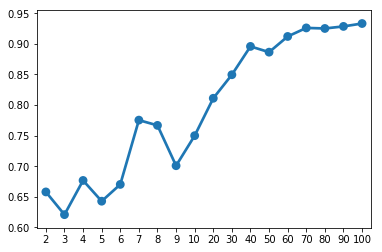

In [7]:
import matplotlib as mpl
import seaborn as sb
%matplotlib inline
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['savefig.facecolor'] = 'white'

km_mats
sb.pointplot(x=K_VALUES, y=km_mats, ymax=1, ymin=0.0)


In [45]:
# Show that decreasing k does not introduce new top_words
top_words = []

print('Doing k = 30...')
# Per-device
# Per-cluster
km = KMeans(n_clusters=30)
clusters = km.fit_predict(tfidf_mat_dev)
df['cluster'] = clusters
texts = ['\n'.join(c['article_content']) for _,c in df.groupby('cluster')]
tfidf_mat, tfidf_ft, tfidf_scores, tfidf_sorted = tfidf(list(texts))
top_words.append([tfidf_ft[t_s[0][0]] for _,t_s in tfidf_sorted.items()])

print('Doing k = 100...')
# Per-device
# Per-cluster
km = KMeans(n_clusters=100)
clusters = km.fit_predict(tfidf_mat_dev)
df['cluster'] = clusters
texts = ['\n'.join(c['article_content']) for _,c in df.groupby('cluster')]
tfidf_mat, tfidf_ft, tfidf_scores, tfidf_sorted = tfidf(list(texts))
top_words.append([tfidf_ft[t_s[0][0]] for _,t_s in tfidf_sorted.items()])

Doing k = 30...


Doing k = 100...


In [47]:
for w in top_words[0]:
    if w not in top_words[1]:
        print(w)

button
recognition
flame


In [24]:
from sklearn import metrics

labels_true = df['simple_category'].factorize()[0]
labels_pred = df['cluster']
metrics.normalized_mutual_info_score(labels_true, labels_pred)

0.41347916400078139

In [81]:
df[['device_name', 'simple_category']]

                                           device_name simple_category
0                                          1-Ring Moon        security
1                 Feit Electric 6.5W Vintage Style LED           light
3                 Honeywell Smart Home Security System        security
5                      Noon Smart Lighting Starter Kit           light
7                                         Wink Lookout        security
9                                       Guardzilla 360        security
10                             Cherry Labs Cherry Home        security
14                                       Remo+ DoorCam        security
16                      Sylvania Smart Plus Zigbee LED           light
19          Philips 60W Replacement WarmGlow Clear LED           light
21                                  Netgear Arlo Pro 2        security
22                                   Vivint Smart Home        security
23                                           Lifx Beam           light
24    

In [58]:
# Display
from IPython.display import display

print('{} clusters'.format(k))
print('{} stop words'.format(len(iot_stops)))
print()

for i, group in df.groupby('cluster'):
    print('Cluster '+str(i))
    print(', '.join(['{} ({:.2f})'.format(tfidf_ft[w], s) for w,s in tfidf_sorted[i]]))
    display(group[['device_name', 'simple_category']])

5 clusters
69 stop words

Cluster 0
like (0.23), battery (0.16)


,device_name,simple_category
14,Remo+ DoorCam,security
27,Lifx Tile,light
62,Ring Spotlight Cam,security
105,LookOut Charger,security
174,Switchmate Power,outlet
232,Kuna Toucan,security
236,LuDela Smart Candle,light
239,Nest Cam Outdoor,security
248,Bosch 360 Degree Indoor Camera,security
294,Kuna Light Fixture,light


Cluster 1
like (0.24), color (0.20)


,device_name,simple_category
1,Feit Electric 6.5W Vintage Style LED,light
19,Philips 60W Replacement WarmGlow Clear LED,light
31,Cree 100W Replacement BR30 Floodlight LED,light
44,Philips SceneSwitch BR30 LED,light
101,Hyperikon 60W Equivalent LED,light
132,Philips 60W Equivalent SceneSwitch LED,light
133,GE 60W Equivalent HD Light LED,light
310,Philips 40W Equivalent Candelabra LED,light
311,Cree TW Series 40W Equivalent Candelabra LED,light
337,GE 40W Replacement Vintage-Style Filament LED2...,light


Cluster 2
like (0.24), doe (0.16)


,device_name,simple_category
0,1-Ring Moon,security
3,Honeywell Smart Home Security System,security
7,Wink Lookout,security
9,Guardzilla 360,security
10,Cherry Labs Cherry Home,security
22,Vivint Smart Home,security
25,Samsung SmartThings ADT Home Security Starter Kit,security
35,Tend Secure Lynx Solar Outdoor Camera,security
51,Reolink Argus Security Camera,security
54,Honeywell Lyric C1 Wi-Fi Security Camera,security


Cluster 3
color (0.32), like (0.29)


,device_name,simple_category
5,Noon Smart Lighting Starter Kit,light
16,Sylvania Smart Plus Zigbee LED,light
23,Lifx Beam,light
30,Lifx Mini Wi-Fi Smart Bulb,light
34,Wiz Color Wi-Fi Smart LED Starter Kit,light
48,Nanoleaf Aurora Rhythm,light
53,Sylvania Smart Multicolor LED,light
61,Swidget Outlet,outlet
82,Elgato Eve Degree,air
93,Ikea Tradfri Smart Lighting Kit,light


Cluster 4
alarm (0.47), smoke (0.39)


,device_name,simple_category
21,Netgear Arlo Pro 2,security
24,Ring Protect,security
69,Halo Smart Labs Halo+ Smart Smoke & CO Alarm w...,air
109,Abode Starter Kit,security
173,Ooma Home Monitoring System,security
177,Netatmo Smart Smoke Alarm,air
190,Somfy One,security
205,Roost Smart Smoke Alarm RSA-400,air
227,Netatmo Healthy Home Coach,air
247,Bosch Eyes Outdoor Camera,security
